# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
# only leave this in if you run on Udacity environment!
# Installs all the dependencies in the python folder
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

# please do not modify the line below
# open the Unity environment Banana
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# environments in Unity contain a brain; set it to the default brain
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# check that this is indeed the BananaBrain we need
# Note that this is continuous space, observation space is 37, action space is 4
print(brain)

Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
# env_info = env.reset(train_mode = True)[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)
print('States have length:', state_size)
print('\n')
print('States look like:', state)

Number of agents: 1
Number of actions: 4
States have length: 37


States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [6]:
# This I've taken out. Got me 0 rewards, but got 'pipe broken' errors once I tried to reload the Unity environment.

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [7]:
# import the the Qnetwork class, not as separate file
# Note: simple 3-layer NN with relu layers and 2 64 neuron deep layers
# Note: super(QNetwork) utiziles existing class Qnetwork

import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
# check to see if the class is indeed made
print(QNetwork)

<class '__main__.QNetwork'>


In [9]:
# import the Agent as well, agent will use Qnetwork function approximator to learn
# import the Replay Buffer
# Give agent two types of DQN, basic and dueling DQN

import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate (very small number)
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, qnetwork, state_size, action_size, update_type, seed):
        """Initialize an Agent object.
        
        Params
        ======
            qnetwork (torch.nn.Module): model to use as the function approximator
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            update_type (str): 'dqn' or 'double-dqn'
            seed (int): random seed
        """
        # initialize all basics: state_size, action-size
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.update_type = update_type

        # Q-Network: local network and target network
        self.qnetwork_local = qnetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = qnetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory, based on class in the same cell
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model   
        # 
        if self.update_type == 'DQN':
            Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        elif self.update_type == 'DOUBLE-DQN':
            best_local_actions = self.qnetwork_local(states).max(1)[1].unsqueeze(1)
            double_dqn_targets = self.qnetwork_target(next_states)
            Q_targets_next = torch.gather(double_dqn_targets, 1, best_local_actions)
        
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss between expected and targets, TD logic
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss in the classic way
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
# initialize the agent
# put in the values of this environment
agent = Agent(state_size = state_size, action_size = action_size, qnetwork = QNetwork, update_type = 'DOUBLE-DQN', seed = 0)

In [11]:
# check to see if the object agent indeed exists
print(agent)

## Time to train the agent!

In [19]:
# engage in the the actual Deep Q Learning training
# note that env_info value is critical here

def dqn(episodes, max_t, eps_start, eps_end, eps_decay):
    scores = [] # scores initialized as list
    scores_window = deque(maxlen=100) # only store 100 scores in scores_window
    eps = eps_start
    
    # loop over episodes
    for i_episode in range(1, episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset function needed here, this function is key!
        state = env_info.vector_observations[0]           # get initial
        score = 0
        
        # loop over time
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]                  # get the reward
            done = env_info.local_done[0]                 # check if done
            
            agent.step(state, action, reward, next_state, done)
            score += reward
            
            state = next_state
            if done:
                break
            
        scores_window.append(score)
        scores.append(score) 
        
        eps = max(eps_end, eps * eps_decay)        # update epsilon value
        
        average_score = np.mean(scores_window)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores

In [20]:
# set params
episodes = 2000 # 1000 would have been fine!
max_t = 2000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

# parameters already set to standard in function
# prints every 100 episodes
scores = dqn(episodes, max_t, eps_start, eps_end, eps_decay)

Episode 100	Average Score: 0.14
Episode 200	Average Score: 1.90
Episode 300	Average Score: 5.41
Episode 400	Average Score: 9.48
Episode 500	Average Score: 11.89
Episode 600	Average Score: 14.04
Episode 700	Average Score: 15.64
Episode 800	Average Score: 15.90
Episode 900	Average Score: 16.03
Episode 1000	Average Score: 16.52
Episode 1100	Average Score: 16.21
Episode 1200	Average Score: 17.14
Episode 1300	Average Score: 16.72
Episode 1400	Average Score: 17.12
Episode 1500	Average Score: 17.19
Episode 1600	Average Score: 16.92
Episode 1700	Average Score: 16.74
Episode 1800	Average Score: 16.15
Episode 1900	Average Score: 16.41
Episode 2000	Average Score: 16.60


## Plot the outcomes visually 

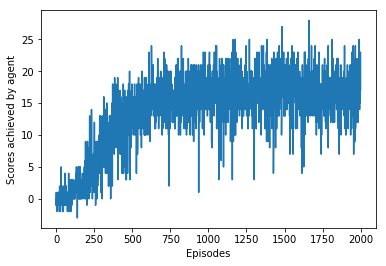

In [32]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot() 
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Scores achieved by agent')
plt.xlabel('Episodes') 
plt.show()

In [ ]:
# reloading the model would work with agent.qnetwork_local.load_state_dict(torch.load())